In [1]:
import os 

os.environ["ISISROOT"] = "/usgs/cpkgs/anaconda3_linux/envs/isis3.7.0"

import pysis
from pysis import isis

import knoten
import json

from ale import util

import ale
from ale.drivers.mro_drivers import MroCtxPds3LabelNaifSpiceDriver
from ale.formatters.usgscsm_formatter import to_usgscsm

from IPython.display import Image

import plotly
plotly.offline.init_notebook_mode(connected=True)

In [2]:
url = 'https://pds-imaging.jpl.nasa.gov/data/mro/mars_reconnaissance_orbiter/ctx/mrox_3365/data/K11_057871_1602_XN_19S163W.IMG'

# !wget -N -P data/ {url}
fileName = 'data/' + os.path.split(url)[1]
camera = knoten.csm.create_csm(fileName)

In [3]:
# Set the output location of the resulting .cub
cub_loc = os.path.splitext(fileName)[0] + '.cub'

# try: 
#     isis.mroctx2isis(from_=fileName, to=cub_loc)
# except ProcessError as e:
#     print(e.stderr)

# try:
#     results = isis.spiceinit(from_=cub_loc, shape='ellipsoid')
# except ProcessError as e:
#     print(e.stderr)

# try:
#     results = isis.footprintinit(from_=cub_loc)
# except ProcessError as e:
#     print(e.stderr)
    
util.write_metakernel_from_cube(cub_loc, '/home/krodriguez/mro_2018_v05.tm')

with MroCtxPds3LabelNaifSpiceDriver(fileName) as driver:
    usgscsmString = to_usgscsm(driver)
    usgscsm_dict = json.loads(usgscsmString)
    
    csm_isd = os.path.splitext(fileName)[0] + '.json'
    json.dump(usgscsm_dict, open(csm_isd, 'w'))

In [4]:
from knoten import vis


csmisis_diff_lv_plot, csmisis_diff_ephem_plot, external_orientation_data = vis.external_orientation_diff(csm_isd, cub_loc, 10, 50, 600, 600)

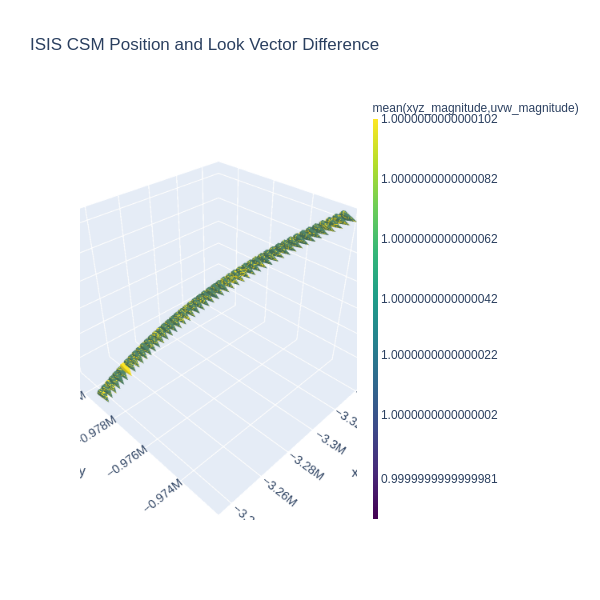

In [5]:
csmisis_diff_lv_plot_bytes = csmisis_diff_lv_plot.to_image(format="png")
csmisis_diff_ephem_plot_bytes = csmisis_diff_ephem_plot.to_image(format="png")
Image(csmisis_diff_lv_plot_bytes)

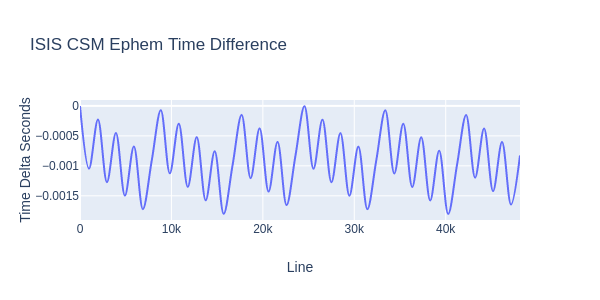

In [6]:
Image(csmisis_diff_ephem_plot_bytes)

In [7]:
external_orientation_data[['diffx', 'diffy', 'diffz', 'diffu', 'diffv', 'diffw']].describe()

,diffx,diffy,diffz,diffu,diffv,diffw
count,500.000000,5.000000e+02,5.000000e+02,500.000000,5.000000e+02,500.000000
mean,1.123220,-5.185950e-02,-2.897793e+00,-0.000006,9.708559e-06,0.000009
std,0.678267,4.249276e-02,1.744058e+00,0.000002,3.063363e-07,0.000006
min,-0.000264,-1.634804e-01,-5.850695e+00,-0.000010,8.898593e-06,-0.000001
25%,0.553333,-8.065253e-02,-4.377824e+00,-0.000008,9.509257e-06,0.000004
50%,1.108990,-4.189675e-02,-2.889207e+00,-0.000006,9.673143e-06,0.000009
75%,1.739575,-1.605547e-02,-1.429424e+00,-0.000004,9.898993e-06,0.000014
max,2.334312,1.047738e-09,2.002344e-08,-0.000002,1.069781e-05,0.000019


In [8]:
isis2csm_plot, csm2isis_plot, isiscsm_plotlatlon, isiscsm_plotbf, isis2csm_data, csm2isis_data, isiscsm_latlondata, isiscsm_bfdata = vis.reprojection_diff(csm_isd, cub_loc, 10, 50, 500, 500)

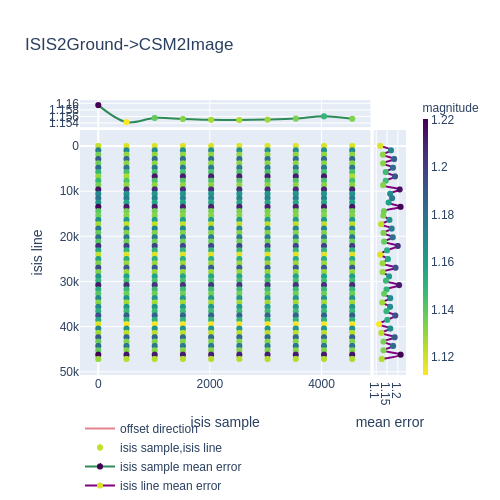

In [9]:
Image(isis2csm_plot.to_image())

In [10]:
isis2csm_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,500.000000,500.000000
mean,-0.575414,-1.001211
std,0.050220,0.012208
min,-0.674595,-1.053845
25%,-0.618258,-1.007713
50%,-0.571841,-0.999328
75%,-0.533542,-0.994139
max,-0.477260,-0.969938


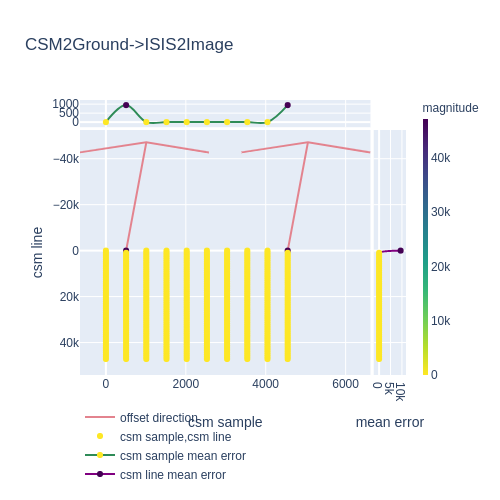

In [11]:
Image(csm2isis_plot.to_image())

In [12]:
csm2isis_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,500.000000,500.000000
mean,-188.090408,3.023068
std,2980.014595,31.942988
min,-47164.881127,0.970023
25%,0.536959,0.993656
50%,0.567522,0.999124
75%,0.605063,1.005993
max,0.665682,506.571137


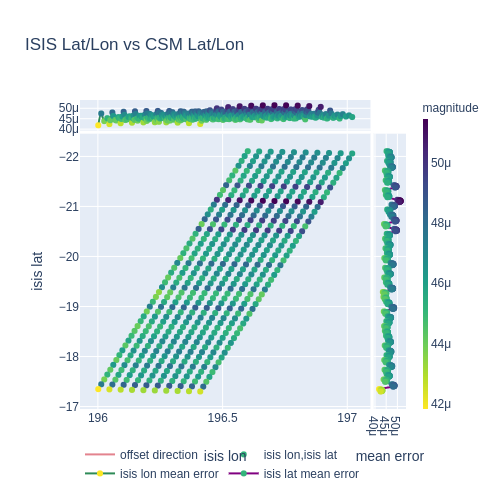

In [13]:
Image(isiscsm_plotlatlon.to_image())

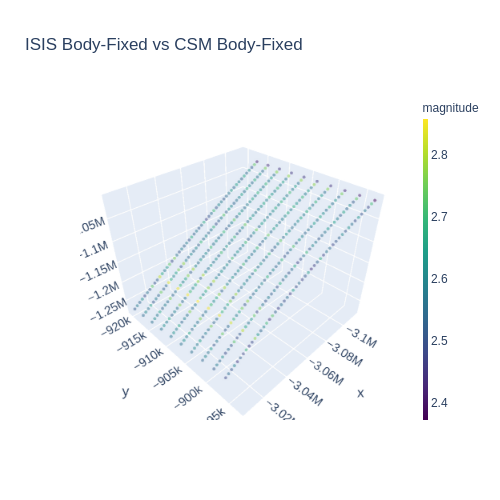

In [14]:
Image(isiscsm_plotbf.to_image())

In [15]:
isiscsm_bfdata[['diffx', 'diffy', 'diffz']].describe()

,diffx,diffy,diffz
count,500.000000,500.000000,500.000000
mean,2.871683,-2.448999,0.683634
std,0.093150,0.064387,0.248639
min,2.682881,-2.705231,0.178476
25%,2.797354,-2.482741,0.486002
50%,2.873945,-2.445863,0.661510
75%,2.942568,-2.411141,0.875251
max,3.068874,-2.249844,1.204739
